In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from functools import reduce
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

#### Constrained optimization

In this notebook, we will look into how we can optimize functions beyond gradient descent. We will also have constraints that affect our solution. Gradient Descent with constraints is solved using Projected Gradient Descent.


#### Example 1:

We are solving the following constrained problem:
<center>

minimize $x^{2}+y^{2}+z^{2}$

given $x+y+z=1$

Solution: $(\frac{1}{3},\frac{1}{3},\frac{1}{3})$
</center>
The above solution can be found using Lagrange multiplers.

In [2]:
func = lambda w: w.T @ w
consts = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1})

w0 = [2,4,8]
minimize(func, w0, constraints=consts)

     fun: 0.33333333333333337
     jac: array([0.66666668, 0.66666668, 0.66666668])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.33333333, 0.33333333, 0.33333333])

#### Example 2: Minimizing Negative Log-Likelihood (NLL Loss) - Logistic Regression

We will try optimizing the NLL loss and obtain weights for Logistic Regression model setup. We can do the same using Gradient Descent as well.
Note that only for linearly separable data, the decision boundary/hypothesis function has the potential to obtain 100% accuracy in correctly classifying data. Here, we will try to generate linearly separable data and get hypothesis by optimizing NLL loss.

In [3]:
def make_data(low, high, n_pts, include_bias):
    X = np.random.uniform(low, high, size=(n_pts, 2))
    Y = np.zeros(shape=(n_pts,))
    
    # making linearly separable data
    pos_idx = np.where(X[:,0] + X[:,1] >= 1)[0]
    neg_idx = np.where(X[:,0] + X[:,1] <= -1)[0]
    Y[pos_idx] = 1
    
    chosen_idxs = np.append(pos_idx, neg_idx)
    X = X[chosen_idxs]
    Y = Y[chosen_idxs]
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.show()
    
    # incorporating bias term
    if include_bias:
        one = np.ones(X.shape[0]).reshape(-1,1)
        X = np.hstack((one, X))    
    return X, Y

def get_splits(X, Y, test_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def get_accuracy(X, y_true, theta, threshold):
    y_pred = (sigmoid(X @ theta) >= threshold) * 1
    return accuracy_score(y_true, y_pred)

#### Important Points: 

1. We will also implement numerically stable version of sigmoid since it can run into numerical overflow and underflow issues while exploring the search space.
2. Since probabiltiies can be zero and likelihood is product of probabilities, the log-likelihood can approach negative infinity. We specify a tolerance level to deal with this issue.

In [4]:
# numerically stable sigmoid
def sigmoid(x):
    pos_mask = x>=0
    neg_mask = x<0
    sig_x_den = np.zeros(x.shape)
    sig_x_den[pos_mask] = np.exp(-x[pos_mask])
    sig_x_den[neg_mask] = np.exp(x[neg_mask])

    sig_x_num = np.ones(x.shape)
    sig_x_num[neg_mask] = sig_x_den[neg_mask]
    sig_x = sig_x_num / (1 + sig_x_den)
    return sig_x

def bernoulli_func(p, y):
    return p**y * (1-p)**(1-y)

def negative_log_likelihood(X, Y, theta, eps):
    score = list(map(lambda x: sigmoid(x), X @ theta))
    probs = list(map(lambda p, y: bernoulli_func(p,y), score, Y))
    L = reduce(lambda x, y: x*y, probs)
    
    # specifying tolerance for zero likelihood values
    LL = np.log(L + eps)
    NLL = -LL
    return NLL

def run_optimization(X_train, y_train, eps, bounds):
    theta_init = np.random.normal(size=(X_train.shape[1],))
    func = lambda theta: negative_log_likelihood(X_train, y_train, theta, eps)
    sol = minimize(func, theta_init, bounds=bounds)
    return sol    

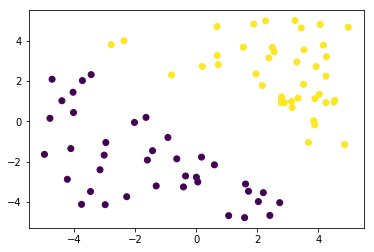

      fun: 4.349824216193576e-06
 hess_inv: array([[  693.91406674, -6793.07356131, -7339.54050867],
       [-6793.07356147, 66571.72399615, 71926.18812031],
       [-7339.54050912, 71926.18812019, 77711.56062026]])
      jac: array([ 2.54065901e-06, -9.21640833e-06,  4.36605922e-06])
  message: 'Optimization terminated successfully.'
     nfev: 224
      nit: 23
     njev: 56
   status: 0
  success: True
        x: array([-0.41378974, 11.98927914, 12.56738274]) 

Best Accuracy: 1.0


In [5]:
low = 5
high = -5
n_pts = 100
test_size = 0.2
random_state = 42
threshold = 0.5
eps = 1E-8
include_bias = True
bounds = None

X, Y = make_data(low, high, n_pts, include_bias)
X_train, X_test, y_train, y_test = get_splits(X, Y, test_size, random_state)

best_sol = None
best_sol_theta = None
best_acc = -1
n_iters = 100

for _ in range(n_iters):
    sol = run_optimization(X_train, y_train, eps, bounds)    
    sol_found = sol.success
    if sol_found:
        sol_theta = sol.x
        acc_score = get_accuracy(X_test, y_test, sol_theta, threshold)
        if acc_score > best_acc:
            best_acc = acc_score
            best_sol = sol
            best_sol_theta = sol_theta

print(best_sol,'\n')
print('Best Accuracy:', best_acc)  

#### Example 3: Linear SVM (Support Vector Machine)

In this example, we will try to solve the maximum margin classifier (Linear SVM) problem for linearly separable data. 

The problem is defined as follows:
<center>

minimize $\frac{W^{\top} W}{2}$

given $\quad y_{i}\left(w x_{i}+b\right) \geqslant 1$

</center>

In [6]:
def run_optimization(X, Y):
    w0 = np.random.normal(size=(X.shape[1],))
    loss_fn = lambda w: (w[1]**2 + w[2]**2) / 2
    consts = ({'type': 'ineq', 'fun': lambda w: Y * (X @ w) - 1})
    sol = minimize(loss_fn, w0, constraints=consts)
    return sol
    
def get_accuracy(X, y_true, sol):
    w = sol.x    
    y_pred = (X @ w > 0) * 1
    y_pred = 2 * y_pred - 1    
    return accuracy_score(y_true, y_pred)

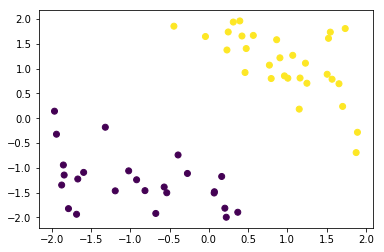

     fun: 0.5742150015493086
     jac: array([0.        , 0.79253944, 0.72132605])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.01240409, 0.79253943, 0.72132604]) 

Accuracy Score: 1.0


In [7]:
low = 2
high = -2
n_pts = 100
include_bias = True
test_size = 0.2
random_state = 42

X, Y = make_data(low, high, n_pts, include_bias)

# re-labelling data from (0,1) to (-1,1)
Y = 2 * Y -1
X_train, X_test, y_train, y_test = get_splits(X, Y, test_size, random_state)
sol = run_optimization(X_train, y_train)
print(sol,'\n')

acc_score = get_accuracy(X_test, y_test, sol)
print('Accuracy Score:', acc_score)  

#### Example 4: Minimizing Ordinary Least Squares (OLS) with constraints - Linear Regression

We will use diabetes toy dataset from sklearn to model a regression problem while minimizing Least Squares function. However, we will also incorporate some constraints on the hypothesis function. 

The description of features is given on sklearn's website. The target variable is disease progression.
Let's assume that there is higher likelihood of progression with increasing values of features i.e. the regression coefficients are non-negative. We will model this as a constraint. Essentially, we are modelling non-negative least squares optimization.

The same problem can also be solved using **Projected Gradient Descent** i.e. Gradient Descent with constraints. There you project the iterative solution vector into constrained space while optimizing.

In [8]:
test_size = 0.2
random_state = 42

dataset = load_diabetes()
X = dataset['data']
Y = dataset['target']

X_train, X_test, y_train, y_test = get_splits(X, Y, test_size, random_state)    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

In [9]:
def OLS(X, Y, theta):
    return np.sum((Y - X @ theta)**2) / X.shape[0]

def run_optimization(X_train, y_train):
    theta_init = np.random.normal(size=(X_train.shape[1],))
    func = lambda theta: OLS(X_train, y_train, theta)
    consts = ({'type':'ineq', 'fun': lambda theta: theta})
    sol = minimize(func, theta_init, constraints=consts)
    return sol    

def get_rmse(theta, X, y_true):
    y_pred = X @ theta
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
best_sol = None
best_sol_theta = None
best_rmse = float('inf')
n_iters = 100

for _ in range(n_iters):
    sol = run_optimization(X_train, y_train)    
    sol_found = sol.success
    if sol_found:
        sol_theta = sol.x
        iter_rmse = get_rmse(sol_theta, X_test, y_test)
        if iter_rmse < best_rmse:
            best_rmse = iter_rmse
            best_sol = sol
            best_sol_theta = sol_theta

print(best_sol,'\n')
print('Best RMSE:', best_rmse.round(3))            

     fun: 26078.566714447657
     jac: array([-9.76562500e-04,  6.03759766e-01,  4.88281250e-04, -2.44140625e-04,
        1.23315430e+00,  1.01733398e+00,  8.61328125e-01,  4.88281250e-04,
       -2.44140625e-04,  4.88281250e-04])
 message: 'Optimization terminated successfully'
    nfev: 589
     nit: 52
    njev: 52
  status: 0
 success: True
       x: array([3.60213311e+01, 6.01758237e-15, 7.19401481e+02, 2.82693241e+02,
       1.70394462e-13, 1.30162359e-13, 1.39730399e-15, 1.36019184e+00,
       4.68192752e+02, 1.29697896e+02]) 

Best RMSE: 164.931
